# Комиссии

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'

## Подготовка данных

In [2]:
df = pd.read_csv('../csv/SBER_101001_201001_1d.csv',
		delimiter=',',
		parse_dates=[[0,1]],
		index_col=0,
		names=['Date','Time','Open', 'High', 'Low', 'Close', 'Volume'],
		header=0,
		encoding='utf-8'
	)

In [3]:
df['Buy'] = (df['Close']-df['Open'])/df['Open']
df['Sell'] = (df['Open']-df['Close'])/df['Open']

## Вспомогательные функции

In [4]:
def calc_n_days(values, n):
    """Проверяет есть ли n дней подряд открытия или закрытия для покупок или продаж.

    Args:
		values [list of float]: массив разницы в % между открытием и закрытие за n предыдущих дней
        n [int]: количество дней, за которые нужно проверять

	Returns:
		[float]: разница в % между открытием и закрытием за текущий день (или NaN)
    """
    if (values[:n] < 0).all():
        return values[-1]
    else:
        return np.nan

In [5]:
def calc_n_days_buysell(values, n):
    """Проверяет есть ли n дней подряд открытия или закрытия для покупок и продаж вместе.

    Args:
		values [list of float]: массив разницы в % между открытием и закрытие за n предыдущих дней
        n [int]: количество дней, за которые нужно проверять

	Returns:
		[float]: разница в % между открытием и закрытием за текущий день c учетом покупки или продажи (или NaN)
    """

    if (values[:n] < 0).all():
        return values[-1]
    elif (values[:n] > 0).all():
        return -1*values[-1]
    else:
        return np.nan

## Основной цикл для рассчёта

In [6]:
commission = 0.06

In [7]:
# n - количество дней, цикл считает до n-1
for n in tqdm(range(1,8)):
    buy_n_days = 'Buy_'+str(n)+'_Days'
    sell_n_days = 'Sell_'+str(n)+'_Days'
    buysell_n_days = 'Buysell_'+str(n)+'_Days'
    equity_buy = 'Equity_'+buy_n_days    
    equity_sell = 'Equity_'+sell_n_days    
    equity_buysell = 'Equity_'+buysell_n_days

    #названия столбцов для данных с комиссией
    equity_buy_commiss = equity_buy+'_Commiss'
    equity_sell_commiss = equity_sell+'_Commiss'
    equity_buysell_commiss = equity_buysell+'_Commiss'

    df[buy_n_days] = df['Buy'].rolling(n+1).apply(calc_n_days, args=(n,))
    df[equity_buy] = df[buy_n_days].cumsum().apply(np.exp)

    df[sell_n_days] = df['Sell'].rolling(n+1).apply(calc_n_days, args=(n,))
    df[equity_sell] = df[sell_n_days].cumsum().apply(np.exp)

    df[buysell_n_days] = df['Buy'].rolling(n+1).apply(calc_n_days_buysell, args=(n,))
    df[equity_buysell] = df[buysell_n_days].cumsum().apply(np.exp)

    #рассчет комиссии
    df[equity_buy_commiss] = (df[buy_n_days]-commission/100*2).cumsum().apply(np.exp)
    df[equity_sell_commiss] = (df[sell_n_days]-commission/100*2).cumsum().apply(np.exp)
    df[equity_buysell_commiss] = (df[buysell_n_days]-commission/100*2).cumsum().apply(np.exp)    
    

100%|██████████| 7/7 [01:25<00:00, 12.20s/it]


## Графики

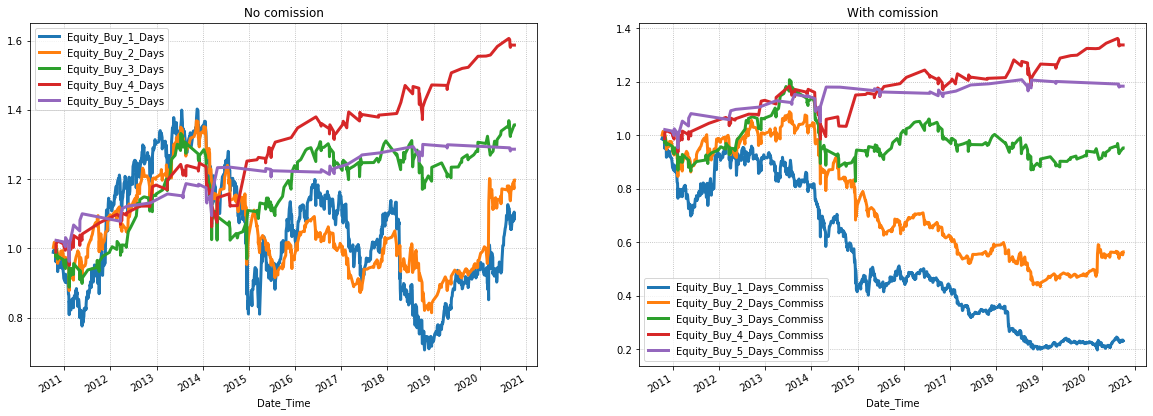

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
df[[
    'Equity_Buy_1_Days',
    'Equity_Buy_2_Days',
    'Equity_Buy_3_Days',
    'Equity_Buy_4_Days',
    'Equity_Buy_5_Days'
]].interpolate(method='index').plot(ax=ax[0], title='No comission')
df[[
    'Equity_Buy_1_Days_Commiss',
    'Equity_Buy_2_Days_Commiss',
    'Equity_Buy_3_Days_Commiss',
    'Equity_Buy_4_Days_Commiss',
    'Equity_Buy_5_Days_Commiss'
]].interpolate(method='index').plot(ax=ax[1], title='With comission')
plt.savefig('../src/equity_buy_1_5_days_commission.png')

In [11]:
# Количество сделок
df[[
    'Equity_Buy_1_Days_Commiss',
    'Equity_Buy_2_Days_Commiss',
    'Equity_Buy_3_Days_Commiss',
    'Equity_Buy_4_Days_Commiss',
    'Equity_Buy_5_Days_Commiss'
]].count()

Equity_Buy_1_Days_Commiss    1291
Equity_Buy_2_Days_Commiss     626
Equity_Buy_3_Days_Commiss     294
Equity_Buy_4_Days_Commiss     142
Equity_Buy_5_Days_Commiss      69
dtype: int64

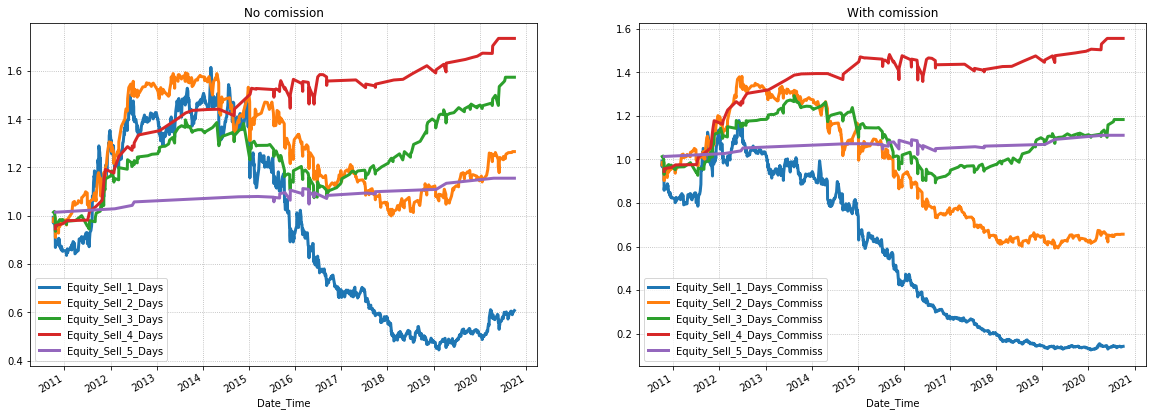

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
df[[
    'Equity_Sell_1_Days',
    'Equity_Sell_2_Days',
    'Equity_Sell_3_Days',
    'Equity_Sell_4_Days',
    'Equity_Sell_5_Days'
]].interpolate(method='index').plot(ax=ax[0], title='No comission')
df[[
    'Equity_Sell_1_Days_Commiss',
    'Equity_Sell_2_Days_Commiss',
    'Equity_Sell_3_Days_Commiss',
    'Equity_Sell_4_Days_Commiss',
    'Equity_Sell_5_Days_Commiss'
]].interpolate(method='index').plot(ax=ax[1], title='With comission')
plt.savefig('../src/equity_sell_1_5_days_commission.png')

In [13]:
# Количество сделок
df[[
    'Equity_Sell_1_Days_Commiss',
    'Equity_Sell_2_Days_Commiss',
    'Equity_Sell_3_Days_Commiss',
    'Equity_Sell_4_Days_Commiss',
    'Equity_Sell_5_Days_Commiss'
]].count()

Equity_Sell_1_Days_Commiss    1212
Equity_Sell_2_Days_Commiss     547
Equity_Sell_3_Days_Commiss     238
Equity_Sell_4_Days_Commiss      91
Equity_Sell_5_Days_Commiss      33
dtype: int64

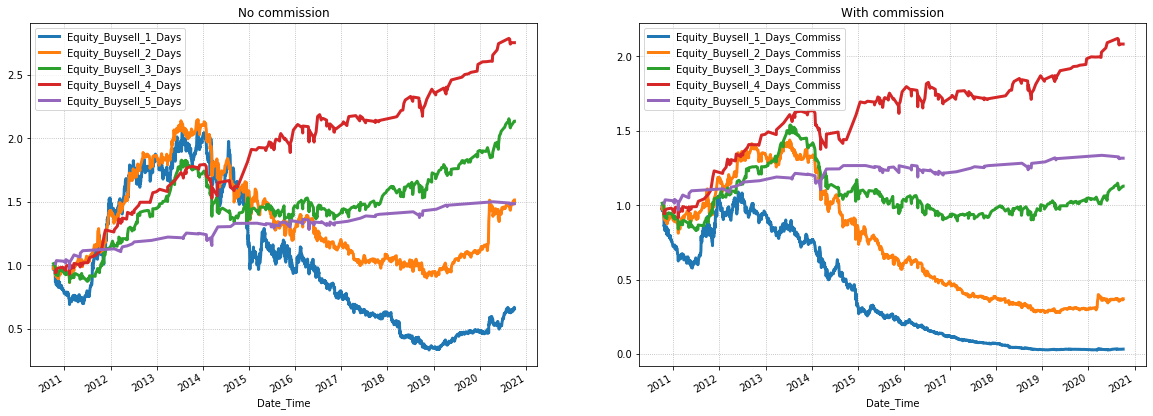

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
df[[
    'Equity_Buysell_1_Days',
    'Equity_Buysell_2_Days',
    'Equity_Buysell_3_Days',
    'Equity_Buysell_4_Days',
    'Equity_Buysell_5_Days'
]].interpolate(method='index').plot(ax=ax[0], title='No commission')
df[[
    'Equity_Buysell_1_Days_Commiss',
    'Equity_Buysell_2_Days_Commiss',
    'Equity_Buysell_3_Days_Commiss',
    'Equity_Buysell_4_Days_Commiss',
    'Equity_Buysell_5_Days_Commiss'
]].interpolate(method='index').plot(ax=ax[1], title='With commission')
plt.savefig('../src/equity_buysell_1_5_days_commission.png')